Индивидуальный проект: **Популярность музыки в сервисе Spotify за 2014-2022**

Автор: **Куготов Алим Заурович**

Проверяющий: **Нечаев Илья Андреевич**

Ссылка на датасет: https://www.kaggle.com/datasets/jfreyberg/spotify-chart-data

# Подготовка данных

**Отключим** все предупреждения по инструкции

In [178]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

pd.set_option("display.max.columns", 100)
import pylab as plt

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)

**Считаем** наш файл с данными

In [179]:
df = pd.read_csv("data/charts.csv")

**Распечатаем** первые 5 записи

In [180]:
df.head(5)

,track_id,name,country,date,position,streams,artists,artist_genres,duration,explicit
0,7GMeRGZax4uDKgz6wALWQw,It Was Always You,br,2015-03-17,138,6584,['Maroon 5'],['pop'],239920,False
1,7GMeRGZax4uDKgz6wALWQw,It Was Always You,br,2015-03-18,132,6963,['Maroon 5'],['pop'],239920,False
2,7GMeRGZax4uDKgz6wALWQw,It Was Always You,br,2015-03-19,128,7049,['Maroon 5'],['pop'],239920,False
3,7GMeRGZax4uDKgz6wALWQw,It Was Always You,br,2015-03-20,152,6976,['Maroon 5'],['pop'],239920,False
4,7GMeRGZax4uDKgz6wALWQw,It Was Always You,br,2015-03-21,160,6156,['Maroon 5'],['pop'],239920,False


# Описание набора данных

In [181]:
print(df.shape)
print(df.columns.values)

(626475, 10)
['track_id' 'name' 'country' 'date' 'position' 'streams' 'artists'
 'artist_genres' 'duration' 'explicit']


Удалим '*track_id*' (сурогатный ключ) и ненужное поле ('*streams*')

In [182]:
df = df.drop(['track_id', 'streams'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626475 entries, 0 to 626474
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           626337 non-null  object
 1   country        626475 non-null  object
 2   date           626475 non-null  object
 3   position       626475 non-null  int64 
 4   artists        626475 non-null  object
 5   artist_genres  626475 non-null  object
 6   duration       626475 non-null  int64 
 7   explicit       626475 non-null  bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 34.1+ MB


|     Название      | Описание                                       |      Тип       |
|---                |:--                                             |:--             |
| **name**          | Название песни                                 | категориальный |
| **country**       | Код страны, в которой появлялась песня в чарте | категориальный |
| **date**          | Дата появление в чарте                         | вещественный   |
| **position**      | Позиция в чарте                                | вещественный   |
| **artists**       | Авторы (исполнители) песни                     | категориальный |
| **artist_genres** | Жанры, в которых исполнители выступают         | категориальный |
| **duration**      | Длительность песни в (ms)                      | вещественный   |
| **explicit**      | Возрастное ограничение (есть/нет)              | бинарный       |

Целевая переменная **position** - Позиция в чарте (в зависимости от страны)

In [183]:
# Отдельно сохраним два list-а для удобства
print(f'TOP {df.position.max()}')
print(f'unique songs: {df.name.nunique()}')
print(f'unique artists: {df.artists.nunique()}')
print(f'unique countries: {df.country.nunique()}')

print(f'max duration: {df.duration.max()}')
print(f'min duration: {df.duration.min()}')

TOP 200
unique songs: 6854
unique artists: 3383
unique countries: 71
max duration: 943528
min duration: 0


# Очистка мусора

Дубликатов нет:

In [184]:
df.duplicated().sum()

0

Сразу заметим, что при вызове функции ***df.info()***, что кол-во строк в признаке **name** меньше, чем у остальных. 

Давайте проверим, ещё раз, на всякий случай, и взглянем, что внутри

In [185]:
df[df.isnull().any(axis=1)]

,name,country,date,position,artists,artist_genres,duration,explicit
122828,NaN,global,2017-11-09,32,['Various Artists'],[],0,True
122829,NaN,global,2017-11-10,30,['Various Artists'],[],0,True
122830,NaN,global,2017-11-11,26,['Various Artists'],[],0,True
122831,NaN,global,2017-11-12,27,['Various Artists'],[],0,True
122832,NaN,global,2017-11-13,31,['Various Artists'],[],0,True
...,...,...,...,...,...,...,...,...
122961,NaN,jp,2017-11-12,172,['Various Artists'],[],0,True
122962,NaN,jp,2017-11-13,177,['Various Artists'],[],0,True
122963,NaN,jp,2017-11-14,182,['Various Artists'],[],0,True
122964,NaN,hu,2017-11-11,164,['Various Artists'],[],0,True


Во всех этих строках длительность песни равна нулю. Очевидно, что эти данные нам не нужны, но перед удалением, изучим их поля: страну и позицию. Возможно, сможем предположить, почему какие-то даннные замусорились

Видим, что в странах JP (Япония) и HU(Венгрия) - возможно, специфичные языки не смогли отобразиться нашей в базе (иероглифы и пр). Давайте проверим

In [186]:
garbage = df[df.isnull().any(axis=1)]
garbage.country.unique()

array(['global', 'mx', 'ar', 'es', 'us', 'cl', 'pe', 'co', 'cr', 'it',
       'ec', 'nl', 'py', 'uy', 'gt', 'do', 'pa', 'bo', 'sv', 'ch', 'hn',
       'pt', 'jp', 'hu'], dtype=object)

Видим, что в списке оказались: США (us), Италия(it), Испания(es)

Странно, что тут США вообще делает, давайте посмотрим

In [187]:
garbage[garbage['country']=="us"].head(10)

,name,country,date,position,artists,artist_genres,duration,explicit
122852,NaN,us,2017-11-09,190,['Various Artists'],[],0,True
122853,NaN,us,2017-11-10,182,['Various Artists'],[],0,True
122854,NaN,us,2017-11-11,151,['Various Artists'],[],0,True
122855,NaN,us,2017-11-12,160,['Various Artists'],[],0,True
122856,NaN,us,2017-11-13,170,['Various Artists'],[],0,True
122857,NaN,us,2017-11-14,122,['Various Artists'],[],0,True


Возможно, какие-то странные ребята со странными названиями заскочили на 5 дней в чарты, либо возникли проблемы с лицензиями между исполнителями и Spotify

Напоследок, убедимся, не проходил ли кто-либо в топ-10:

In [188]:
garbage[garbage['position']<10].head()

,name,country,date,position,artists,artist_genres,duration,explicit
122834,NaN,mx,2017-11-09,2,['Various Artists'],[],0,True
122835,NaN,mx,2017-11-10,2,['Various Artists'],[],0,True
122836,NaN,mx,2017-11-11,2,['Various Artists'],[],0,True
122837,NaN,mx,2017-11-12,2,['Various Artists'],[],0,True
122838,NaN,mx,2017-11-13,2,['Various Artists'],[],0,True


Моё итоговое предположение - исполнители удалили свои песни или возникли проблемы в плане лицензии. Но я не уверен, тк, например, A$AP ROCKY, который был в топах яндекс музыки, наверняка, лежит где-то в бд по чартам 2012-2014 годов. Соц сети могут по 10 лет хранить личные данные, а важная информация, для отслеживания вкусов потребителей уж тем более не будет удаляться. Так и не пришёл к выводам - возможно, датасет с просто с косяками

**Очистим** лишний мусор

In [189]:
zero_duration = (df[df['duration']==0])
df = df.drop(zero_duration.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626337 entries, 0 to 626474
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           626337 non-null  object
 1   country        626337 non-null  object
 2   date           626337 non-null  object
 3   position       626337 non-null  int64 
 4   artists        626337 non-null  object
 5   artist_genres  626337 non-null  object
 6   duration       626337 non-null  int64 
 7   explicit       626337 non-null  bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 38.8+ MB


# EDA

Интересно проследить за спросом на отсутствие цензуры:

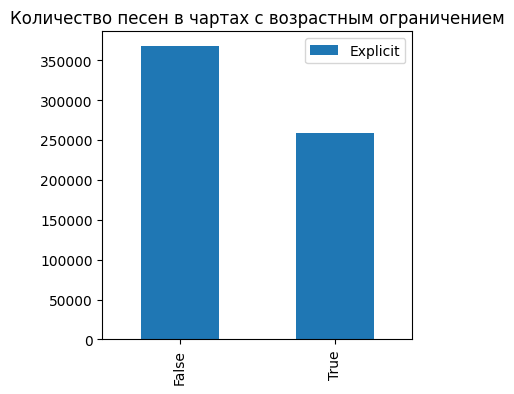

In [190]:
df["explicit"].value_counts().plot(kind="bar", label="Explicit", figsize=(4,4))
plt.legend()
plt.title("Количество песен в чартах с возрастным ограничением");

Количественных переменных у нас не так много, поэтому не вижу смысла делать корреляцию

<AxesSubplot: >

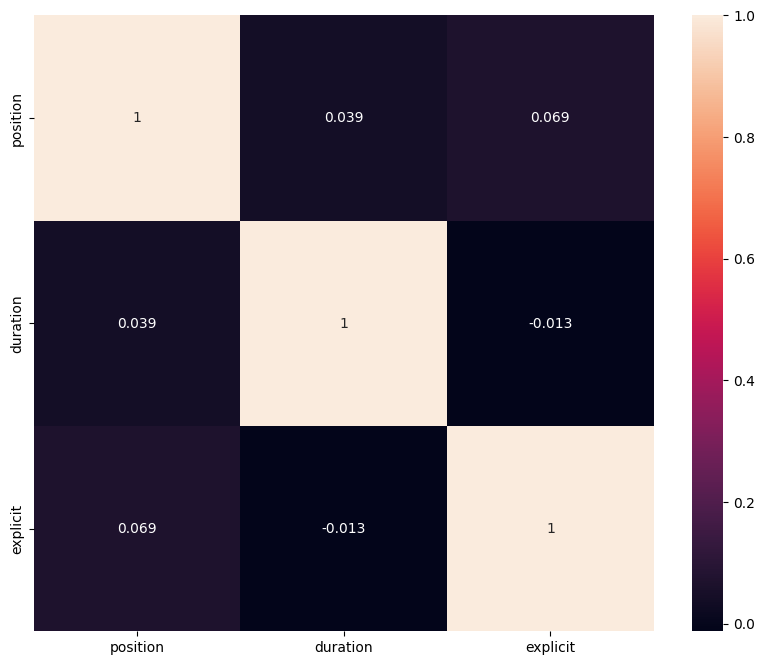

In [191]:
# в colab не работает
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)

Видим, что везде **низкая корреляция** - логично, тк эти поля не особо связаны

Построим гистограмму для количественных значений и убедимся, что, в целом, ничего неожиданного:
- чем выше рейтинг, тем меньше песен
- средняя длительность трека : 350 секунд ~ 5-6 минут

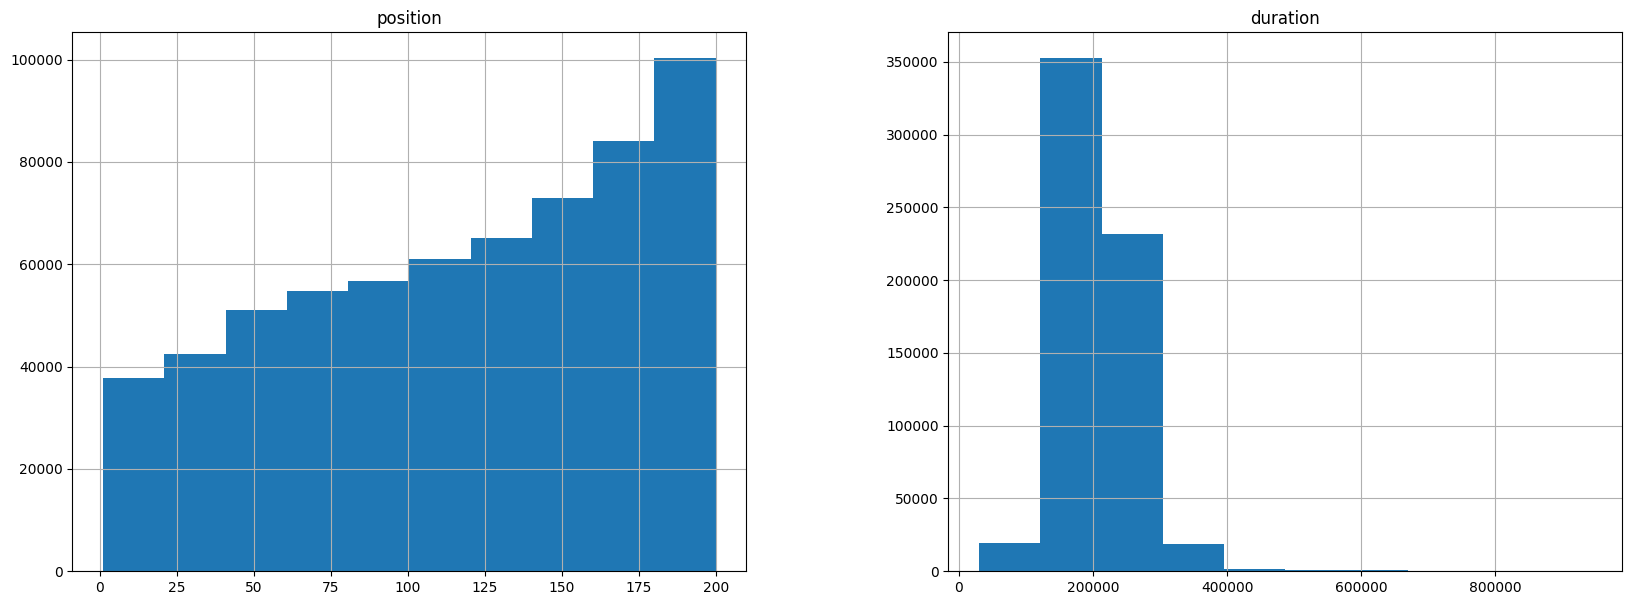

In [192]:
df.hist(figsize=(20, 7));

Найдём топ 10 стран, где активнее всего работает spotify, и проведём маленькую статистику:

In [193]:
# Как из методички - по всем странам
df.groupby(["country"])["position"].agg([np.mean]).sort_values(by="mean", ascending=False).T

country,br,tr,jp,us,id,in,ca,no,it,pt,pl,sa,nz,vn,th,ph,za,hu,au,fr,be,il,nl,my,cz,fi,ie,sg,de,dk,se,ru,gb,tw,ro,ch,kr,at,do,global,cl,es,hk,gr,ua,cr,co,ar,pe,ae,ma,eg,sk,pa,mx,hn,cy,uy,sv,ec,bo,lt,ni,bg,py,gt,lv,is,ee,mt,lu
mean,137.184511,133.269947,131.9653,131.610914,131.419201,127.537836,125.420636,125.336354,124.738148,123.971678,123.959757,123.551839,123.183197,122.758002,122.149911,121.834591,121.471704,121.124146,121.039797,120.944544,120.635012,120.519965,120.473633,120.172449,119.602118,119.250797,118.575005,118.490932,118.455641,118.373281,117.736127,117.150124,117.03174,116.941899,115.817432,115.295775,114.601247,114.095374,113.941441,113.049082,112.872452,112.83876,112.071698,110.569219,110.551,110.529663,110.26224,107.819454,106.509354,105.787163,104.786683,104.635261,104.555467,101.960611,100.233734,99.170222,96.3,96.019557,94.760174,93.801599,92.594511,91.621781,88.697092,85.054242,84.771162,81.699738,78.351195,73.835006,57.971152,57.268293,35.976744


In [194]:
# более подробно по топу 10 стран
groupped_country = df.groupby(['country']).mean()
groupped_country = groupped_country.sort_values(by=['position'], ascending=False)
groupped_country.head(10)

,position,duration,explicit
country,,,
br,137.184511,210721.211803,0.218801
tr,133.269947,222277.491689,0.264295
jp,131.965300,204318.017744,0.177050
us,131.610914,206732.509704,0.679633
id,131.419201,212912.387544,0.190979
in,127.537836,199372.418226,0.224166
ca,125.420636,206861.672861,0.604129
no,125.336354,207121.225554,0.348381
it,124.738148,208106.402604,0.250307


Давайте посмотрим, как зависит возрастное ограничение от позиции в топе в разные эпохи:

In [195]:
years = pd.DatetimeIndex(df['date']).year
print(f'from: {years.min()} to {years.max()}')

from: 2014 to 2022


In [196]:
df_2014 = df[pd.DatetimeIndex(df['date']).year == 2014].groupby('explicit').position.describe()
df_2015 = df[pd.DatetimeIndex(df['date']).year == 2015].groupby('explicit').position.describe()
df_2016 = df[pd.DatetimeIndex(df['date']).year == 2016].groupby('explicit').position.describe()
df_2017 = df[pd.DatetimeIndex(df['date']).year == 2017].groupby('explicit').position.describe()
df_2018 = df[pd.DatetimeIndex(df['date']).year == 2018].groupby('explicit').position.describe()
df_2019 = df[pd.DatetimeIndex(df['date']).year == 2019].groupby('explicit').position.describe()
df_2020 = df[pd.DatetimeIndex(df['date']).year == 2020].groupby('explicit').position.describe()
df_2021 = df[pd.DatetimeIndex(df['date']).year == 2021].groupby('explicit').position.describe()
df_2022 = df[pd.DatetimeIndex(df['date']).year == 2022].groupby('explicit').position.describe()

In [197]:
df_2014.head()

,count,mean,std,min,25%,50%,75%,max
explicit,,,,,,,,
False,4842.0,127.235440,43.799928,5.0,94.0,128.0,164.0,200.0
True,1534.0,130.147979,42.970775,23.0,92.0,135.0,167.0,200.0


Данные собираю немного туповатым способом, сразу же извиняюсь, более аккуратного не придумал

In [198]:
mean_false = np.empty(9, dtype='float64')
mean_true = np.empty(9, dtype='float64')
mean_false[0] = df_2014.values[0][1]
mean_false[1] = df_2015.values[0][1]
mean_false[2] = df_2016.values[0][1]
mean_false[3] = df_2017.values[0][1]
mean_false[4] = df_2018.values[0][1]
mean_false[5] = df_2019.values[0][1]
mean_false[6] = df_2020.values[0][1]
mean_false[7] = df_2021.values[0][1]
mean_false[8] = df_2022.values[0][1]

mean_true[0] = df_2014.values[1][1]
mean_true[1] = df_2015.values[1][1]
mean_true[2] = df_2016.values[1][1]
mean_true[3] = df_2017.values[1][1]
mean_true[4] = df_2018.values[1][1]
mean_true[5] = df_2019.values[1][1]
mean_true[6] = df_2020.values[1][1]
mean_true[7] = df_2021.values[1][1]
mean_true[8] = df_2022.values[1][1]

In [199]:
p25_false = np.empty(9, dtype='float64')
p25_true = np.empty(9, dtype='float64')

p25_false[0] = df_2014.values[0][4]
p25_false[1] = df_2015.values[0][4]
p25_false[2] = df_2016.values[0][4]
p25_false[3] = df_2017.values[0][4]
p25_false[4] = df_2018.values[0][4]
p25_false[5] = df_2019.values[0][4]
p25_false[6] = df_2020.values[0][4]
p25_false[7] = df_2021.values[0][4]
p25_false[8] = df_2022.values[0][4]

p25_true[0] = df_2014.values[1][4]
p25_true[1] = df_2015.values[1][4]
p25_true[2] = df_2016.values[1][4]
p25_true[3] = df_2017.values[1][4]
p25_true[4] = df_2018.values[1][4]
p25_true[5] = df_2019.values[1][4]
p25_true[6] = df_2020.values[1][4]
p25_true[7] = df_2021.values[1][4]
p25_true[8] = df_2022.values[1][4]

In [200]:
p75_false = np.empty(9, dtype='float64')
p75_true = np.empty(9, dtype='float64')

p75_false[0] = df_2014.values[0][6]
p75_false[1] = df_2015.values[0][6]
p75_false[2] = df_2016.values[0][6]
p75_false[3] = df_2017.values[0][6]
p75_false[4] = df_2018.values[0][6]
p75_false[5] = df_2019.values[0][6]
p75_false[6] = df_2020.values[0][6]
p75_false[7] = df_2021.values[0][6]
p75_false[8] = df_2022.values[0][6]

p75_true[0] = df_2014.values[1][6]
p75_true[1] = df_2015.values[1][6]
p75_true[2] = df_2016.values[1][6]
p75_true[3] = df_2017.values[1][6]
p75_true[4] = df_2018.values[1][6]
p75_true[5] = df_2019.values[1][6]
p75_true[6] = df_2020.values[1][6]
p75_true[7] = df_2021.values[1][6]
p75_true[8] = df_2022.values[1][6]

In [201]:
mean_false = pd.Series(mean_false, name='mean_false')
mean_true = pd.Series(mean_true, name='mean_true')

p25_false = pd.Series(p25_false, name='p25_false')
p25_true = pd.Series(p25_true, name='p25_true')

p75_false = pd.Series(p75_false, name='p75_false')
p75_true = pd.Series(p75_true, name='p75_true')

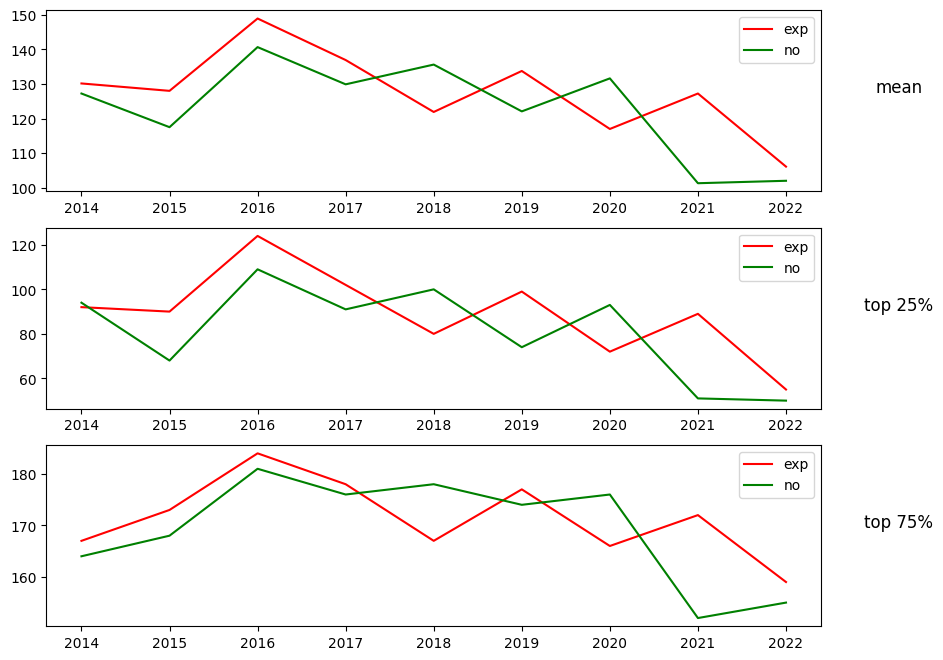

In [202]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(mean_true, color='r', label='exp')
ax1.plot(mean_false, color='g', label='no')
ax1.set_title('mean', x = 1.1, y = 0.5)

ax2.plot(p25_true, color='r', label='exp')
ax2.plot(p25_false, color='g', label='no')
ax2.set_title('top 25%', x = 1.1, y = 0.5)

ax3.plot(p75_true, color='r', label='exp')
ax3.plot(p75_false, color='g', label='no')
ax3.set_title('top 75%', x =1.1, y = 0.5)

years = np.empty(10, dtype=int)
for i in range(10):
    years[i] = 2013 + i
    
ax1.set_xticklabels(years)
ax2.set_xticklabels(years)
ax3.set_xticklabels(years)

ax1.legend()
ax2.legend()
ax3.legend()

В целом видим, что спрос на музыку с цензурой и без примерно одинаков, не считая 2021 года. В 2019 всколохнул Covid-19, далее последовали экономические кризисы и войны, может быть, это и отразилось на спрос. Можно было бы углубиться, и узнать, в каких именно странах происходил рост, чтоб подтвердить догадки, но оставим вопрос открытым

# Поиск аномалий

Перед поиском, нужно установить библиотеку (работаю на локальном ПК с jupyter-notebook):
```bash
pip install -U scikit-learn scipy matplotlib
```

Переделаем категориальные переменные в вещественные:

In [203]:
from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()
df['name']= enc.fit_transform(df['name'])
df['country']= enc.fit_transform(df['country'])
df['date']= enc.fit_transform(df['date'])
df['artists']= enc.fit_transform(df['artists'])
df['artist_genres']= enc.fit_transform(df['artist_genres'])
df['explicit']= enc.fit_transform(df['explicit'])

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626337 entries, 0 to 626474
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   name           626337 non-null  int32
 1   country        626337 non-null  int32
 2   date           626337 non-null  int32
 3   position       626337 non-null  int64
 4   artists        626337 non-null  int32
 5   artist_genres  626337 non-null  int32
 6   duration       626337 non-null  int64
 7   explicit       626337 non-null  int64
dtypes: int32(5), int64(3)
memory usage: 31.1 MB


In [205]:
df.head()

,name,country,date,position,artists,artist_genres,duration,explicit
0,2895,7,162,138,2030,2371,239920,0
1,2895,7,163,132,2030,2371,239920,0
2,2895,7,164,128,2030,2371,239920,0
3,2895,7,165,152,2030,2371,239920,0
4,2895,7,166,160,2030,2371,239920,0


In [206]:
df.describe().style.background_gradient()

,name,country,date,position,artists,artist_genres,duration,explicit
count,626337.000000,626337.000000,626337.000000,626337.000000,626337.000000,626337.000000,626337.000000,626337.000000
mean,3464.701252,35.916547,1975.374734,116.631531,1590.474444,1933.318145,207335.782903,0.412655
std,1973.623932,22.484187,877.706723,57.023766,986.437225,997.061370,53558.869171,0.492312
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,30133.000000,0.000000
25%,1744.000000,15.000000,1316.000000,70.000000,745.000000,1084.000000,175986.000000,0.000000
50%,3370.000000,35.000000,2222.000000,124.000000,1528.000000,2160.000000,203672.000000,0.000000
75%,5167.000000,56.000000,2854.000000,167.000000,2492.000000,2725.000000,232786.000000,1.000000
max,6853.000000,70.000000,2886.000000,200.000000,3381.000000,3624.000000,943528.000000,1.000000


<AxesSubplot: >

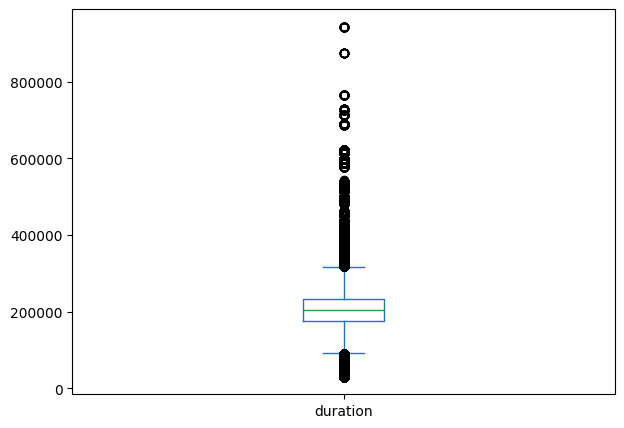

In [207]:
df['duration'].plot.box(figsize=(7,5))

В целом есть аномалии, но они мне кажутся незначительными, поэтому оставлю dataset в покое

# Классификация по возрастному ограничению

In [213]:
df.head()
y=df['explicit']
x=df.drop(columns=['explicit'])
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(x,y,stratify=y)

Установим ещё одну библиотеку:
```bash
pip install xgboost
```

In [214]:
from xgboost import XGBClassifier
model=XGBClassifier()
# Тренируем модель
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [215]:
# Делаем предсказания
from sklearn.metrics import classification_report
y_predict = model.predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     92376
           1       0.98      0.99      0.98     64209

    accuracy                           0.99    156585
   macro avg       0.99      0.99      0.99    156585
weighted avg       0.99      0.99      0.99    156585



Предсказания работают просто отлично, поэтому едем дальше

Напоследок, проверим confusion matrix: 

In [217]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_train)
res = confusion_matrix(y_train,predictions)
print("Training confusion matrix")
print(res)

predictions= svc_model .predict(X_test)
res=confusion_matrix(y_test,predictions)
print("Testing confusion matrix")
print(res)

Training confusion matrix
[[273320   2587]
 [  3740 190105]]
Testing confusion matrix
[[91214   755]
 [ 1113 63503]]


В целом, видим хорошие результаты и с улыбкой сдаём работу :D